# Overview

Example of loading text data and metadata in Python and visualizing some interactions between patterns in metadata and text (simple word frequencies).

The text data is organized as text files in directories. The metadata for documents in the corpus is in a CSV file.

# Load data

In [3]:
# Read in metadata as a dictionary of pandas dataframes

import os
import pandas as pd

# pandas display settings
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 10000)

metadata_dirpath = '/usr2/scratch/fanfic/'

fandoms = [
    'allmarvel',
    'dcu',
    'harrypotter',
    'sherlock',
    'starwars',
    'song_ice_fire',
    'supernatural',
    'teenwolf',
]


metadata = {}
for fandom in fandoms:
    metadata_fpath = os.path.join(metadata_dirpath, f'ao3_{fandom}_text', 'stories.csv')
    metadata[fandom] = pd.read_csv(metadata_fpath)

metadata['allmarvel'].head(3)

,fic_id,title,author,author_key,rating,category,fandom,relationship,character,additional tags,language,published,status,status date,words,comments,kudos,bookmarks,hits,chapter_count,series,seriespart,seriesid
0,1000010,Bellwether,kaige68,kaige68,"[""General Audiences""]","[""M/M""]","[""The Avengers (Marvel Movies)"", ""Agents of S.H.I.E.L.D. (TV)""]","[""Clint Barton/Phil Coulson""]","[""Clint Barton"", ""Phil Coulson""]","[""Drabble"", ""Community: 1_million_words""]",English,2013-10-05,Completed,NaN,100.0,2.0,27.0,1.0,707.0,1,NaN,NaN,NaN
1,1000013,Estrella Nuclear,Badguy_x_Moores,Badguy_x_Moores,"[""Explicit""]","[""M/M""]","[""The Avengers (Marvel Movies)""]","[""Loki/Tony Stark""]","[""Loki (Marvel)"", ""Tony Stark""]","[""Romance"", ""Sex"", ""Slash""]",Español,2013-10-11,Completed,NaN,5037.0,NaN,6.0,NaN,378.0,1,NaN,NaN,NaN
2,1000017,Don't Let Go,helens78,helens78,"[""Teen And Up Audiences""]","[""M/M""]","[""X-Men: First Class (2011) - Fandom""]","[""Erik Lehnsherr/Charles Xavier""]","[""Erik Lehnsherr"", ""Charles Xavier"", ""Kurt Marko""]","[""Community: fan_flashworks"", ""Violence"", ""Alternate Universe - Role Reversal"", ""Role Reversal"", ""First Meetings"", ""Revenge"", ""Childhood Trauma""]",English,2013-09-06,Completed,NaN,1187.0,13.0,229.0,37.0,2497.0,1,NaN,NaN,NaN


In [4]:
# Sample 1000 stories from each fandom, store in a dictionary of IDs with fandom names as the keys

sampled_fic_ids = {}

for fandom in fandoms:
    sampled_fic_ids[fandom] = metadata[fandom]['fic_id'].sample(1000).tolist()
    
sampled_fic_ids['dcu'][:5]

[1886454, 16310165, 5848369, 14242692, 7750189]

# Preprocess data

In this case our data is already preprocessed, but important steps to think about include:

* Lowercasing
    - Does case matter?
* Tokenization: breaking text into words.
    - Almost always a good idea
    - Breaks up possessives (Henry's -> Henry 's)
* Stopwords
    - Are common function words such as "the", "in" or "I" important?
    
### An example before and after preprocessing

BEFORE: The cat's toy sat completely still on the windowsill.  
AFTER: cat 's toy sat completely still windowsill .

In [7]:
# Load preprocessed story text
from tqdm import tqdm_notebook as tqdm

stories_dirpath = '/usr2/mamille2/fanfiction-project/data/ao3/'
stories = {fandom: {} for fandom in fandoms}

# For every fandom, look up the sample ID and load it into the stories dictionary
for fandom in tqdm(fandoms):
    for fic_id in sampled_fic_ids[fandom]:
        story_fpath = os.path.join(stories_dirpath, fandom, 'fics_paras', f'{fic_id}.txt')
        
        if not os.path.exists(story_fpath):
            # Try other naming
            story_fpath = os.path.join(stories_dirpath, fandom, 'fics_paras', f'{fic_id}_tokenized_paras.txt')
            
        if not os.path.exists(story_fpath):
            continue
        
        with open(story_fpath) as f:
            stories[fandom][fic_id] = f.read()
            
stories['teenwolf'][4376255][:100]

'it was a massacre .\nthat was the only way to describe it . a bloody massacre .\na scattered mess , of'

# Visualize some trends

## Basic statistics across fandoms

In [10]:
# Average fic length across fandom

avg_fic_lengths = {}

for fandom in fandoms:
    avg_fic_lengths[fandom] = metadata[fandom]['words'].mean()
    
avg_fic_lengths

{'allmarvel': 6340.572692113122,
 'dcu': 6436.082340756085,
 'harrypotter': 8926.514089454375,
 'sherlock': 5840.655792911082,
 'starwars': 7516.378565865057,
 'song_ice_fire': 9863.427027781656,
 'supernatural': 6234.203054811565,
 'teenwolf': 6474.4850016783475}

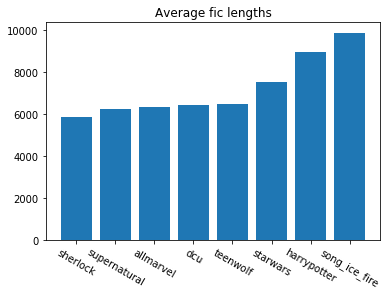

In [11]:
%matplotlib inline

# Graph average fic lengths

import operator

sorted_fic_lengths = sorted(avg_fic_lengths.items(), key=operator.itemgetter(1))
labels, values = list(zip(*sorted_fic_lengths))

import matplotlib.pyplot as plt

plt.title("Average fic lengths")
plt.bar(labels, values)
plt.xticks(rotation=-30)
plt.show()

## Perhaps more interesting...

In [12]:
metadata[fandom]['category'][:5]

0    ["Gen"]  
1    ["Multi"]
2    ["Gen"]  
3    ["M/M"]  
4    ["F/F"]  
Name: category, dtype: object

In [13]:
# Distribution of ships, relationship types across fandoms

proportion_mm = {}

# Proportion of stories with M/M
for fandom in fandoms:
    fics_with_mm = sum(metadata[fandom]['category'].map(lambda x: 'M/M' in x))
#     fics_with_mm = sum(metadata[fandom]['category'].map(lambda x: 'F/F' in x))
#     fics_with_mm = sum(metadata[fandom]['category'].map(lambda x: 'Other' in x))
    proportion_mm[fandom] = fics_with_mm/len(metadata[fandom])
    
proportion_mm

{'allmarvel': 0.47835236541598697,
 'dcu': 0.3677397432059611,
 'harrypotter': 0.47198827247543296,
 'sherlock': 0.6023044217687075,
 'starwars': 0.382001970587162,
 'song_ice_fire': 0.145094645150483,
 'supernatural': 0.6187985977490181,
 'teenwolf': 0.725180280515465}

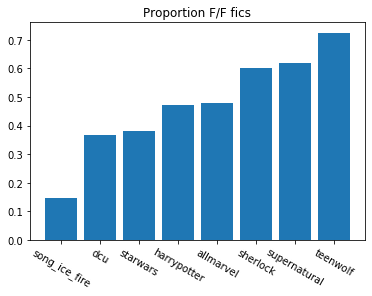

In [14]:
import operator

sorted_proportions = sorted(proportion_mm.items(), key=operator.itemgetter(1))
labels, values = list(zip(*sorted_proportions))

plt.title("Proportion F/F fics")
plt.bar(labels, values)
plt.xticks(rotation=-30)
plt.show()

In [15]:
# Do fandoms with LGBTQ ships use more LGBTQ labels?
lgbtq_labels = ['transgender', 'trans', 'queer', 'lesbian', 'gay', 'homosexual', 'nonbinary', 'non-binary']
cishet_labels = ['heterosexual', 'cisgender', 'cis']

# Count terms
word_totals = {}
lgbtq_term_counts = {fandom: {} for fandom in fandoms} # fandom: term

for fandom in tqdm(fandoms):
    word_totals[fandom] = 0
    for term in lgbtq_labels:
        lgbtq_term_counts[fandom][term] = 0
        for fic_id in sampled_fic_ids[fandom]:
#             lgbtq_term_counts[fandom][term] += stories[fandom][fic_id].replace('\n', ' ').count(term) # add count of term
            lgbtq_term_counts[fandom][term] += term in stories[fandom][fic_id].replace('\n', ' ').split()
#             word_totals[fandom] += len(stories[fandom][fic_id].split()) # total fandom word count
            word_totals[fandom] += 1
            
lgbtq_term_totals = {fandom: sum(lgbtq_term_counts[fandom].values()) for fandom in fandoms}
lgbtq_term_totals

lgbtq_term_proportions = {fandom: lgbtq_term_totals[fandom]/word_totals[fandom] for fandom in fandoms}
lgbtq_term_proportions

{'allmarvel': 0.011,
 'dcu': 0.014125,
 'harrypotter': 0.015375,
 'sherlock': 0.01625,
 'starwars': 0.0045,
 'song_ice_fire': 0.014125,
 'supernatural': 0.01475,
 'teenwolf': 0.0145}

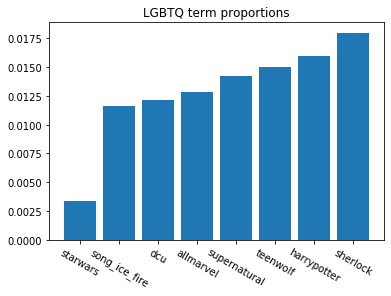

In [29]:
sorted_term_proportions = sorted(lgbtq_term_proportions.items(), key=operator.itemgetter(1))
labels, values = list(zip(*sorted_term_proportions))

plt.title("LGBTQ term proportions")
plt.bar(labels, values)
plt.xticks(rotation=-30)
plt.show()

In [32]:
# Make 2-dimensional features (proportion_mm, lgbtq_term_proportion)

x_vals = []
y_vals = []

for fandom in fandoms:
    x_vals.append(proportion_mm[fandom])
    y_vals.append(lgbtq_term_proportions[fandom])
    
print(x_vals)
print(y_vals)

[0.47835236541598697, 0.3677397432059611, 0.47198827247543296, 0.6023044217687075, 0.382001970587162, 0.145094645150483, 0.6187985977490181, 0.725180280515465]
[0.012875, 0.012125, 0.016, 0.018, 0.003375, 0.011625, 0.01425, 0.015]


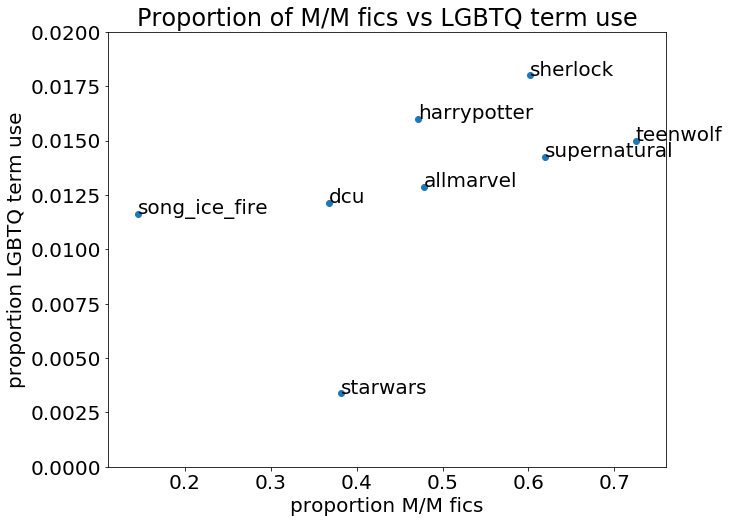

In [33]:
# Plot

font = {'size'   : 20}
plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(x_vals, y_vals)

for i, fandom in enumerate(fandoms):
    ax.annotate(fandom, (x_vals[i], y_vals[i]))
plt.ylim(0, 0.02)
plt.title("Proportion of M/M fics vs LGBTQ term use")
plt.xlabel('proportion M/M fics')
plt.ylabel('proportion LGBTQ term use')
plt.show()

# Find this tutorial

https://github.com/michaelmilleryoder/fanfiction-scripts/blob/master/jupyter/fanfiction_data_visualization.ipynb